Import common libraries:

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import dataset:

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/xgBoostSkenes.csv')
df.head()

,pitch_type,zone,stand,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,inning,...,pitch_number,if_fielding_alignment,of_fielding_alignment,home_score_diff,bat_score_diff,bat_win_exp,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game
0,FF,11,R,1,2,NaN,NaN,683737.0,2,4,...,7,Standard,Strategic,-2,2,0.719,28,3,2,6.0
1,SL,14,R,0,2,NaN,NaN,683737.0,2,4,...,6,Standard,Strategic,-2,2,0.719,28,3,2,6.0
2,CH,13,R,0,2,NaN,NaN,683737.0,2,4,...,5,Standard,Strategic,-2,2,0.719,28,3,2,6.0
3,SL,1,R,0,2,NaN,NaN,683737.0,2,4,...,4,Standard,Strategic,-2,2,0.719,28,3,2,6.0
4,FF,2,R,0,2,NaN,NaN,683737.0,2,4,...,3,Standard,Standard,-2,2,0.719,28,3,2,6.0


Inspecting the dataset

In [ ]:
pd.set_option('display.max_columns', 10)

df.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

# Target variable to predict is type of pitch + zone (FF_10 for example)
df['target'] = df['pitch_type'] + "_" + df['zone'].astype(str)

# Create multiple lags for previous pitch sequence
for i in [1, 2, 3]:
    # Group by game_pk to prevent bleeding across games
    df[f'prev_pitch_{i}'] = df.groupby('game_pk')['pitch_type'].shift(i)
    df[f'prev_zone_{i}'] = df.groupby('game_pk')['zone'].shift(i)

    # Fill NaNs
    # Lag 1 NaNs = First Pitch
    # Lag 2 NaNs = First OR Second Pitch, etc.
    df[f'prev_pitch_{i}'].fillna('None', inplace=True)
    df[f'prev_zone_{i}'].fillna('None', inplace=True)

    # Convert Zone to string for encoding
    df[f'prev_zone_{i}'] = df[f'prev_zone_{i}'].astype(str).str.replace('.0', '', regex=False)

# Convert runners to 0 or 1
for base in ['1b', '2b', '3b']:
    df[f'on_{base}'] = df[f'on_{base}'].notna().astype(int)

cols_to_one_hot = [
    'stand',
    'inning_topbot',
    'fielder_2',
    'if_fielding_alignment',
    'of_fielding_alignment',
    'prev_pitch_1', 'prev_pitch_2', 'prev_pitch_3',
    'prev_zone_1', 'prev_zone_2', 'prev_zone_3'
]

df_encoded = pd.get_dummies(df, columns=cols_to_one_hot, drop_first=True)

df_encoded.head()


cols_to_drop = ['pitch_type', 'zone', 'game_pk']

# Drop them in place
df_encoded.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Label encode the target
le = LabelEncoder()
df_encoded['target_id'] = le.fit_transform(df_encoded['target'])

df_ready = df_encoded.drop(columns=['target'])

df_ready.to_csv('df_ready.csv', index=False)


After feature engineering use XGBoost model to predict pitch type and location

In [ ]:
X = df_ready.drop(columns=['target_id'])
y = df_ready['target_id']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
import numpy as np

# Create a new LabelEncoder specifically for the training target
temp_le_train = LabelEncoder()
y_train_encoded = temp_le_train.fit_transform(y_train)

# Number of classes for the model should be the number of unique classes in the training set
num_classes_in_train = len(y_train.unique())

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes_in_train,
    n_estimators=100,        # Tuned up
    learning_rate=0.05,      # Tuned down
    max_depth=3,             # Shallow to prevent overfit
    subsample=0.8,
    random_state=42
)

model.fit(X_train, y_train_encoded) # Use the re-encoded y_train

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=83, ...)


--- RESULTS ---
Model Accuracy: 0.2332

--- Probability Matrix Snapshot (First Test Pitch) ---
Rank 1: Class ID 23 -> 26.1% probability
Rank 2: Class ID 27 -> 7.6% probability
Rank 3: Class ID 30 -> 6.9% probability


<Figure size 1000x800 with 0 Axes>

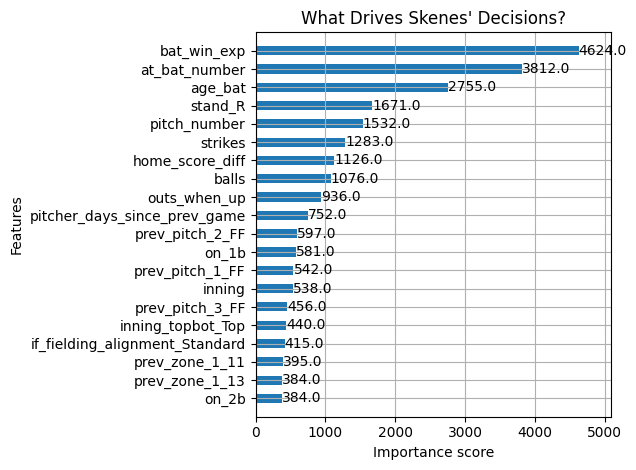

In [ ]:
# This returns an array of shape (N_Test_Rows, N_Classes)
prob_matrix = model.predict_proba(X)

# We take the class with the highest probability as the "Guess"
predictions = model.predict(X)
accuracy = accuracy_score(y, predictions)

print(f"\n--- RESULTS ---")
print(f"Model Accuracy: {accuracy:.4f}")
# Accuracy will be low because predicting exact pitch and zone is difficult

# Look at the first pitch in the Test Set
print("\n--- Probability Matrix Snapshot (First Test Pitch) ---")
# Get probabilities for Pitch #0
p0_probs = prob_matrix[0]

# Sort to find Top 3 most likely options
top_3_indices = p0_probs.argsort()[-3:][::-1]

for rank, class_id in enumerate(top_3_indices, 1):
    probability = p0_probs[class_id]
    print(f"Rank {rank}: Class ID {class_id} -> {probability*100:.1f}% probability")

plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=20, height=0.5, importance_type='weight', title='What Drives Skenes\' Decisions?')
plt.tight_layout()
plt.show()